In [ ]:
import re
import os
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

In [ ]:
os.environ['PYTHONHASHSEED'] = str(1)
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords_en = stopwords.words('english')
stopwords_rf = []
stopwords_ck = []

C_Most_Limit = 25
C_Least_Occurs = 10

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_word_counts(x = 20, y = 10):
    allwordlist, freqwordlist, freqcountlist = [], [], []
    for tweet in dataset_train['text']:
        allwordlist.extend(tweet.split())
    for tweet in dataset_test['text']:
        allwordlist.extend(tweet.split())
    total_words = len(allwordlist)
    print(f"Total number of words after generic preprocessing: {total_words}")
    wordcounts = Counter(allwordlist)
    print("Most Common Words :")
    for key, value in wordcounts.most_common(x):
      stopwords_ck.append(key)
    print(stopwords_ck)
    for key, value in wordcounts.most_common():
      if value <= y:
        stopwords_rf.append(key)

def clean_string(x):
    x = re.sub(r"http\S+", ' ', x)                                                  # Remove hyperlinks
    x = re.sub(r"(?<=\w)([A-Z])", r" \1", x)                                        # Split SentenceCased words (hashtags)
    x = re.sub(r"[^a-zA-Z]", ' ', x)                                                # Remove numerical and special characters
    x = re.sub(r"\s{1,}", ' ', x)                                                   # Dedupe consecutive whitespaces
    x = x.lower()                                                                   # Convert to lower case
    x = [word for word in x.split() if word not in stopwords_en]                    # Stopword removal
    x = [word for word in x if len(word) > 1]                                       # Remove single character words
    x = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in x])             # Normalization of text
    if x == '':
        x = 'good'
    return x

def remove_infrequent_words(x):
    x = ' '.join([word for word in x.split() if word not in stopwords_rf])
    return x

def remove_common_words(x):
    x = ' '.join([word for word in x.split() if word not in stopwords_ck])
    return x

def preprocess_generic():
    dataset_train['text'] = dataset_train['text'].apply(clean_string)
    dataset_test['text'] = dataset_test['text'].apply(clean_string)
    get_word_counts(C_Most_Limit, C_Least_Occurs)
    dataset_train['text'] = dataset_train['text'].apply(remove_infrequent_words)
    dataset_test['text'] = dataset_test['text'].apply(remove_infrequent_words)    

def preprocess_specific():
    dataset_train['text'] = dataset_train['text'].apply(remove_common_words)
    dataset_test['text'] = dataset_test['text'].apply(remove_common_words)    
    return dataset_train['text'], dataset_train['target'], dataset_test['text']

def get_dataset():
    data_train = pd.read_csv("/content/drive/MyDrive/Kaggle/train.csv")
    data_test =  pd.read_csv("/content/drive/MyDrive/Kaggle/test.csv")
    prev_len = len(data_train)
    data_train = data_train.drop_duplicates('text', keep='last')
    print(f"Found and removed #{prev_len - len(data_train)} duplicates from the Training dataset.")
    return data_train, data_test
    
def get_max_tweet_len():
    tweetlen = []
    for tweet in dataset_train['text']:
        tweetlen.append(len(tweet.split()))
    for tweet in dataset_test['text']:
        tweetlen.append(len(tweet.split()))
    return max(tweetlen)

def build_sequences(X_train, X_test):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 2**15, oov_token = '<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen = C_Tweet_Len, padding = 'post')
    X_test = tokenizer.texts_to_sequences(X_test)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = C_Tweet_Len, padding = 'post') 
    return X_train, X_test, len(tokenizer.word_counts) + 2

def plot_generator():
    metrics = ['Binary_Accuracy', 'Loss']
    linetype = ['-', '--']
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    epochs = range(len(history.history[metrics[0].lower()]))
    for i in range(len(metrics)):
        axes[i].plot(epochs, history.history[metrics[i].lower()], 'r'+ linetype[i], label = 'Training')
        axes[i].plot(epochs, history.history['val_' + metrics[i].lower()], 'b' + linetype[i] , label = 'Validation')
        axes[i].set_title(metrics[i])
        axes[i].grid(True)
        axes[i].legend()

In [ ]:
dataset_train, dataset_test = get_dataset()
preprocess_generic()
print("Done")

Found and removed #110 duplicates from the Training dataset.
Total number of words after generic preprocessing: 93872
Most Common Words :
['get', 'like', 'fire', 'amp', 'news', 'go', 'bomb', 'via', 'new', 'one', 'say', 'people', 'good', 'time', 'make', 'kill', 'attack', 'burn', 'crash', 'flood', 'build', 'emergency', 'take', 'see', 'come']
Done


In [ ]:
stopwords_ck = ['get', 'like', 'amp', 'news', 'go', 'via', 'new', 'one', 'say', 'people', 'time', 'make', 'build', 'take', 'see', 'come']
X_train, y_train, X_test = preprocess_specific()
C_Tweet_Len = get_max_tweet_len()
X_train, X_test, C_Emb_Inp_Dim = build_sequences(X_train, X_test)

Epoch 1/100
211/211 [==============================] - 7s 23ms/step - loss: 0.6734 - binary_accuracy: 0.5929 - val_loss: 0.5145 - val_binary_accuracy: 0.7550
Epoch 2/100
211/211 [==============================] - 4s 19ms/step - loss: 0.4703 - binary_accuracy: 0.7766 - val_loss: 0.5019 - val_binary_accuracy: 0.7617
Epoch 3/100
211/211 [==============================] - 4s 19ms/step - loss: 0.4595 - binary_accuracy: 0.7851 - val_loss: 0.4755 - val_binary_accuracy: 0.7710
Epoch 4/100
211/211 [==============================] - 4s 19ms/step - loss: 0.4294 - binary_accuracy: 0.7950 - val_loss: 0.4713 - val_binary_accuracy: 0.7683
Epoch 5/100
211/211 [==============================] - 4s 19ms/step - loss: 0.4318 - binary_accuracy: 0.8008 - val_loss: 0.4663 - val_binary_accuracy: 0.7696
Epoch 6/100
211/211 [==============================] - 4s 18ms/step - loss: 0.4292 - binary_accuracy: 0.7990 - val_loss: 0.4655 - val_binary_accuracy: 0.7723
Epoch 7/100
211/211 [==============================]

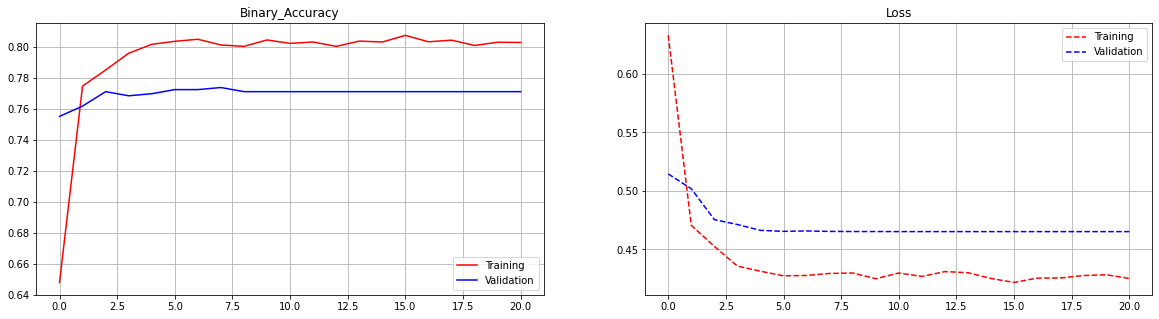

In [ ]:
def lrscheduler(epoch, lr):
#  print(f"Using a learning rate of {lr}")
  if epoch % 2 == 1:
    return lr * 0.2
  else:
    return lr

def callback_def():
    cb = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True),
          tf.keras.callbacks.LearningRateScheduler(lrscheduler),
          tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Kaggle/logs')
         ]
    return cb

def build_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim = C_Emb_Inp_Dim, output_dim = 1, input_length = C_Tweet_Len),
        tf.keras.layers.SpatialDropout1D(0.1),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Conv1D(32, 4),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                  metrics=tf.keras.metrics.BinaryAccuracy()
                  )
    return model
clf = build_model()
history = clf.fit(X_train, y_train, validation_split = 0.1, epochs = 100, verbose = 1, callbacks = callback_def())
plot_generator()

In [ ]:
threshold = 0.3
y_pred = [ele for [ele] in clf.predict(X_test)]
y_pred = [1 if ele > threshold else 0 for ele in y_pred]
subs = pd.DataFrame({"id": dataset_test.id, 'target':y_pred})
subs.to_csv('/content/drive/MyDrive/Kaggle/submission.csv', index=False)

In [ ]:
print(subs)

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]
